In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vit_model/pytorch/files/1/config.json
/kaggle/input/vit_model/pytorch/files/1/preprocessor_config.json
/kaggle/input/vit_model/pytorch/files/1/training_args.bin
/kaggle/input/vit_model/pytorch/files/1/model.safetensors
/kaggle/input/resnet50_model/pytorch/files/1/config.json
/kaggle/input/resnet50_model/pytorch/files/1/preprocessor_config.json
/kaggle/input/resnet50_model/pytorch/files/1/training_args.bin
/kaggle/input/resnet50_model/pytorch/files/1/model.safetensors
/kaggle/input/har25indoor/HARDATA_SHREYA/desktop.ini
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_161.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_206.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_153.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_102.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_002.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_012.jpg
/kaggle/input/har25indo

In [2]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-x4bas2pb
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-x4bas2pb
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 1ff3f58818baa2889f3f51d0b9759783b4333ba0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=37707 sha256=df7d74fceb792f8180546e01b0c11a56b233d1986f74a64f831c089def341bc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-re0itn2c/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [3]:
# import copy
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet18
# import numpy as np
# from PIL import Image
# import torch
# import torch.nn as nn
# import torchvision

In [4]:
import copy
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

In [5]:
#define a test image for the demo
dataset = load_dataset("imagefolder", data_dir =  '/kaggle/input/har25indoor/HARDATA_SHREYA')

Resolving data files:   0%|          | 0/5480 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

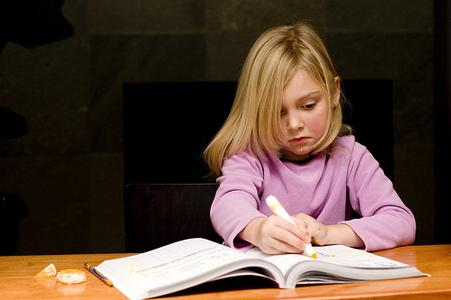

In [66]:
num = 5305
image = dataset["train"][num]['image']

img_tensor = transforms.ToTensor()(image)

image

In [7]:
""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

In [8]:
from transformers import ResNetForImageClassification

model = ResNetForImageClassification.from_pretrained('/kaggle/input/resnet50_model/pytorch/files/1')

In [9]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]  # Remove the class token
    activations = activations.view(activations.shape[0],
                                   14, 14, activations.shape[2])  # Reshape to 14x14 patches
    activations = activations.permute(0, 3, 1, 2)  # Transpose to match (batch, channels, height, width)
    return activations

model2 = ViTForImageClassification.from_pretrained('/kaggle/input/vit_model/pytorch/files/1')

2024-06-12 12:22:29.168154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 12:22:29.168300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 12:22:29.353346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


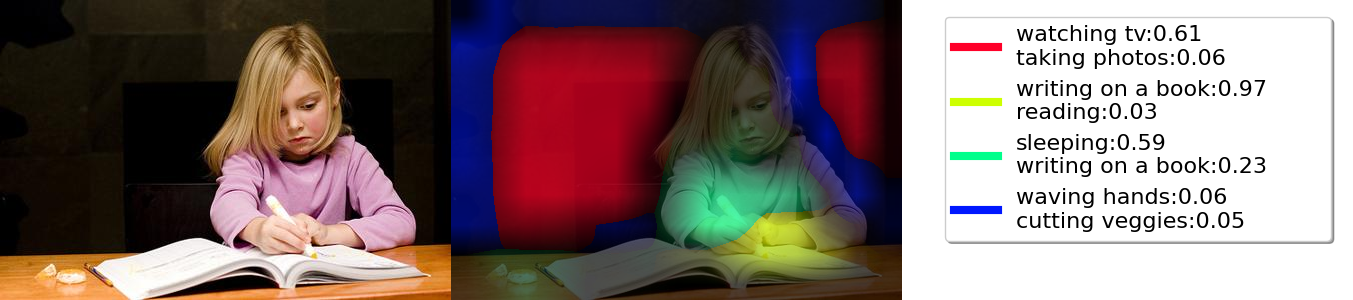

Predicted class 24: writing on a book
Predicted class 14: reading
Predicted class 20: using a computer
Predicted class 16: sleeping
Predicted class 19: texting


In [67]:
target_layer = model.resnet.encoder.stages[-1].layers[-1]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))

print_top_categories(model, img_tensor)

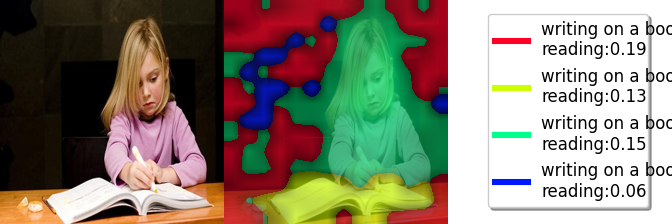

Predicted class 24: writing on a book
Predicted class 14: reading
Predicted class 20: using a computer
Predicted class 19: texting
Predicted class 11: laughing


In [68]:
target_layer_dff = model2.vit.layernorm
target_layer_gradcam = model2.vit.encoder.layer[-2].output
image_resized = image.resize((224, 224))
tensor_resized = transforms.ToTensor()(image_resized)


display(Image.fromarray(run_dff_on_image(model=model2,
                          target_layer=target_layer_dff,
                          classifier=model2.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=4,
                          top_k=2)))

print_top_categories(model2, tensor_resized)